In [1]:
# ! pip install pymvg

In [2]:
sequence_key = 'p7s1'
camera_number = 1
calibraton_file_path_base = "./gait3d/Sequences/{sequence_key}/Calibration/c{camera_number}.xml"
calibraton_file_path_1 = calibraton_file_path_base.format(sequence_key=sequence_key, camera_number=1)
print(calibraton_file_path_1)

calibraton_file_path_2 = calibraton_file_path_base.format(sequence_key=sequence_key, camera_number=2)
print(calibraton_file_path_2)

./gait3d/Sequences/p7s1/Calibration/c1.xml
./gait3d/Sequences/p7s1/Calibration/c2.xml


In [3]:
with open(calibraton_file_path_1) as file:
    xml_calibration_config = file.read()
    print(xml_calibration_config)

<?xml version="1.0" encoding="UTF-8"?>
<Camera name="c1">
	<Geometry width="960" height="540" ncx="9.600000e+002" nfx="9.600000e+002" dx="1.000000e+000" dy="1.000000e+000" dpx="1.000000e+000" dpy="1.000000e+000"/>
	<Intrinsic focal="5.561470e+002" kappa1="2.720130e-007" cx="4.800000e+002" cy="2.700000e+002" sx="1.001630e+000"/>
	<Extrinsic tx="2.564550e+001" ty="6.130300e+002" tz="3.444080e+003" rx="-3.121731e+000" ry="1.353192e+000" rz="1.582054e+000"/>
</Camera>



In [4]:
import xml.etree.ElementTree as ET
import numpy as np
from scipy.spatial.transform import Rotation as R

def parse_camera_xml(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()

    camera_name = root.attrib['name']

    geometry = root.find('Geometry')
    intrinsic = root.find('Intrinsic')
    extrinsic = root.find('Extrinsic')
    
    camera_width = float(geometry.get('width'))
    camera_height = float(geometry.get('height'))

    f = float(intrinsic.get('focal'))
    c = np.array([
        float(intrinsic.get('cx')),
        float(intrinsic.get('cx'))
    ])

    k = np.array([
        float(intrinsic.get('kappa1')), 0.0, 0.0
        # k2=0 and k3=0 - not provided in file 
    ])

    p = np.array([0.0, 0.0])  # p - not provided in file

    T = np.array([
        [float(extrinsic.get("tx"))],
        [float(extrinsic.get("ty"))],
        [float(extrinsic.get("tz"))]
    ]).reshape(3, 1)

    rx, ry, rz = float(extrinsic.get("rx")), float(extrinsic.get("ry")), float(extrinsic.get("rz"))
    R_matrix = R.from_euler('xyz', [rx, ry, rz]).as_matrix()

    return {
        "name": camera_name,
        "width": camera_width,
        "height": camera_height,
        "R": R_matrix,
        "T": T,
        "f": f,
        "c": c,
        "k": k,
        "p": p
    }



In [5]:
parse_camera_xml(calibraton_file_path_1)

{'name': 'c1',
 'width': 960.0,
 'height': 540.0,
 'R': array([[-0.00243038,  0.99995771, -0.0088693 ],
        [ 0.21587739, -0.00813555, -0.97638659],
        [-0.97641746, -0.00428767, -0.21584849]]),
 'T': array([[  25.6455],
        [ 613.03  ],
        [3444.08  ]]),
 'f': 556.147,
 'c': array([480., 480.]),
 'k': array([2.72013e-07, 0.00000e+00, 0.00000e+00]),
 'p': array([0., 0.])}

In [6]:
# code based on https://github.com/microsoft/multiview-human-pose-estimation-pytorch/tree/master

import numpy as np
from pymvg.camera_model import CameraModel
from pymvg.multi_camera_system import MultiCameraSystem


def unfold_camera_param(camera):
    """
    Camera parameters:
        R: 3x3 Camera rotation matrix
        T: 3x1 Camera translation parameters
        f: (scalar) Camera focal length
        c: 2x1 Camera center
        k: 3x1 Camera radial distortion coefficients
        p: 2x1 Camera tangential distortion coefficients
    """
    R = camera['R']
    T = camera['T']
    f = camera['f'] # 0.5 * (camera['fx'] + camera['fy'])
    c = camera['c'] # np.array([camera['cx'], camera['cy']])
    k = camera['k']
    p = camera['p']
    return R, T, f, c, k, p


def build_multi_camera_system(cameras):
    """
    Build a multi-camera system with pymvg package for triangulation

    Args:
        cameras: list of camera parameters
    Returns:
        cams_system: a multi-cameras system
    """
    pymvg_cameras = []
    for camera in cameras:
        R, T, f, c, k, p = unfold_camera_param(camera)
        camera_matrix = np.array(
            [[f, 0, c[0]], [0, f, c[1]], [0, 0, 1]], dtype=float)
        distortion = np.array([k[0], k[1], p[0], p[1], k[2]])
        distortion.shape = (5,)
        # T = -np.matmul(R, T)
        M = camera_matrix.dot(np.concatenate((R, T), axis=1))
        camera = CameraModel.load_camera_from_M(
            M, name=camera['name'], distortion_coefficients=distortion,
            width=camera['width'], height=camera['height']
        )
        pymvg_cameras.append(camera)
    return MultiCameraSystem(pymvg_cameras)


def triangulate_one_point(camera_system, points_2d_set):
    """
    Triangulate 3d point in world coordinates with multi-views 2d points

    Args:
        camera_system: pymvg camera system
        points_2d_set: list of structure (camera_name, point2d)
    Returns:
        points_3d: 3x1 point in world coordinates
    """
    points_3d = camera_system.find3d(points_2d_set)
    return points_3d


def triangulate_poses(cameras_params, poses2d):
    """
    Triangulate 3d points in world coordinates of multi-view 2d poses
    by interatively calling $triangulate_one_point$

    Args:
        camera_params: a list of camera parameters, each corresponding to single camera
        poses2d: ndarray of shape nxkx2, len(cameras) == n
    Returns:
        poses3d: ndarray of shape n/nviews x k x 3
    """
    nviews = poses2d.shape[0]
    njoints = poses2d.shape[1]
    ninstances = 1 #len(camera_files_paths)

    poses3d = []
    for i in range(ninstances):
        camera_system = build_multi_camera_system(cameras_params)

        pose3d = np.zeros((njoints, 3))
        for k in range(njoints):
            points_2d_set = []

            for j in range(nviews):
                camera_name = 'c{}'.format(j+1)
                points_2d = poses2d[i * nviews + j, k, :]
                points_2d_set.append((camera_name, points_2d))
            pose3d[k, :] = triangulate_one_point(camera_system, points_2d_set).T
        poses3d.append(pose3d)
    return np.array(poses3d)


In [7]:
from utils.video_tools import get_camera_calibration_files, get_video_files

sequence_key = "p1s1"

camera_files_paths = get_camera_calibration_files(sequence_key)
cameras_params = [parse_camera_xml(camera_path) for camera_path in camera_files_paths]
cameras_params

[{'name': 'c1',
  'width': 960.0,
  'height': 540.0,
  'R': array([[ 0.00120615,  0.99999022,  0.0042542 ],
         [ 0.21610251,  0.00389302, -0.97636292],
         [-0.97636994,  0.00209698, -0.2160957 ]]),
  'T': array([[  21.1943],
         [ 613.873 ],
         [3393.53  ]]),
  'f': 546.711,
  'c': array([480., 480.]),
  'k': array([3.05309e-07, 0.00000e+00, 0.00000e+00]),
  'p': array([0., 0.])},
 {'name': 'c2',
  'width': 960.0,
  'height': 540.0,
  'R': array([[-0.99992544, -0.01190427,  0.002721  ],
         [-0.00425836,  0.13109134, -0.99136115],
         [ 0.01144473, -0.99129882, -0.13113225]]),
  'T': array([[ -62.0904],
         [ 618.389 ],
         [5207.65  ]]),
  'f': 553.247,
  'c': array([480., 480.]),
  'k': array([6.18469e-07, 0.00000e+00, 0.00000e+00]),
  'p': array([0., 0.])},
 {'name': 'c3',
  'width': 960.0,
  'height': 540.0,
  'R': array([[-0.01314138, -0.99977742,  0.01650498],
         [-0.22256503, -0.01316765, -0.97482892],
         [ 0.97482927, -0.01

In [8]:
mcs = build_multi_camera_system(cameras_params)
mcs

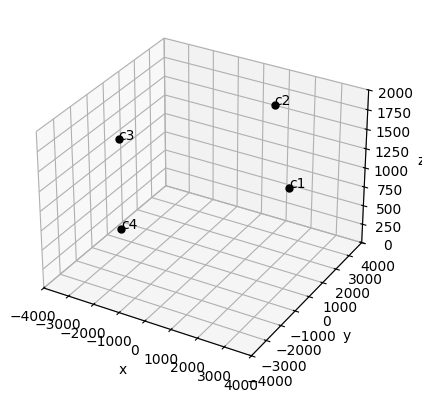

In [9]:
from pymvg.plot_utils import plot_system
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
plot_system( ax, mcs )
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
ax.set_xlim(-4000, 4000); ax.set_ylim(-4000, 4000); ax.set_zlim(0, 2000)
plt.show()

In [10]:
video_files = get_video_files(sequence_key)
video_files

['./gait3d/Sequences/p1s1/Images/c1_0195.avi',
 './gait3d/Sequences/p1s1/Images/c2_0195.avi',
 './gait3d/Sequences/p1s1/Images/c3_0195.avi',
 './gait3d/Sequences/p1s1/Images/c4_0195.avi']

In [11]:
from scripts.frame_iterator import video_frame_iterator
from utils.mediapipe_estimator import MediaPipeEstimator

frames_iterator = [video_frame_iterator(avi_file) for avi_file in video_files]
mp_estimators = [MediaPipeEstimator() for _ in range(4)]
predicted = [{} for _ in range(4)]
MAX_FRAMES = 80

for frame_i in range(MAX_FRAMES):
    for iter_ind, (f_iterator, mp_estimator) in enumerate(zip(frames_iterator, mp_estimators)):
        frame_ts, frame = next(f_iterator)
        estimations = mp_estimator.predict_for_frame(frame_ts, frame)
        predicted[iter_ind][frame_i] = estimations

C:\Users\Miko7\Studia\magisterka\gait-features-identification\venv\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


[Frame 0] Landmarks not found!
[Frame 40] Landmarks not found!
[Frame 80] Landmarks not found!
[Frame 120] Landmarks not found!
[Frame 160] Landmarks not found!
[Frame 200] Landmarks not found!
[Frame 240] Landmarks not found!
[Frame 280] Landmarks not found!
[Frame 320] Landmarks not found!
[Frame 360] Landmarks not found!
[Frame 400] Landmarks not found!
[Frame 440] Landmarks not found!
[Frame 480] Landmarks not found!
[Frame 520] Landmarks not found!
[Frame 560] Landmarks not found!
[Frame 600] Landmarks not found!
[Frame 640] Landmarks not found!
[Frame 680] Landmarks not found!
[Frame 720] Landmarks not found!
[Frame 760] Landmarks not found!
[Frame 800] Landmarks not found!
[Frame 840] Landmarks not found!
[Frame 880] Landmarks not found!
[Frame 920] Landmarks not found!
[Frame 960] Landmarks not found!
[Frame 1000] Landmarks not found!
[Frame 1040] Landmarks not found!
[Frame 1080] Landmarks not found!
[Frame 1120] Landmarks not found!
[Frame 1160] Landmarks not found!
[Frame 12

In [12]:
predicted[0][0]

[(873, 128),
 (879, 123),
 (880, 123),
 (882, 123),
 (877, 123),
 (878, 123),
 (878, 123),
 (891, 125),
 (885, 125),
 (878, 135),
 (876, 135),
 (915, 159),
 (873, 156),
 (909, 204),
 (870, 198),
 (903, 243),
 (864, 228),
 (904, 255),
 (861, 238),
 (898, 254),
 (860, 237),
 (897, 249),
 (862, 235),
 (890, 240),
 (867, 236),
 (889, 297),
 (868, 291),
 (887, 350),
 (864, 343),
 (891, 358),
 (869, 352),
 (860, 363),
 (841, 353)]

In [13]:
predicted[3][0]

[]

In [14]:
sample_2d_points = np.array([predicted[i][75] for i in [0,1,2,3]])
sample_2d_points.shape

(4, 33, 2)

In [15]:
sample_result = triangulate_poses(cameras_params, sample_2d_points)
sample_result

array([[[-155.09820165, -497.97463935, 2959.51699812],
        [-143.81287468, -486.32460238, 2981.57988266],
        [-137.11402153, -481.46797857, 2982.34600014],
        [-129.14669682, -476.66207691, 2983.09946475],
        [-165.73377332, -484.10030002, 2984.54010124],
        [-172.44383637, -481.46591791, 2986.28049814],
        [-179.70683511, -476.7288864 , 2986.12610074],
        [-110.42639261, -443.89239831, 2977.28795742],
        [-190.01436519, -439.84107904, 2974.34679679],
        [-144.44251575, -482.80807911, 2933.46076956],
        [-166.75466045, -480.58646876, 2936.44437192],
        [ -18.27806244, -383.92895384, 2814.6959573 ],
        [-291.10049405, -395.92993823, 2817.09122002],
        [   6.4712981 , -376.24285862, 2577.82927965],
        [-320.44931854, -397.80833573, 2579.09030932],
        [  27.18043228, -427.47980504, 2377.70636414],
        [-343.36269295, -455.98394685, 2368.25942115],
        [  32.92719777, -423.79050112, 2319.90817888],
        [-

In [16]:
x = sample_result[0, :, 0]
y = sample_result[0, :, 1]
z = sample_result[0, :, 2]
x

array([-155.09820165, -143.81287468, -137.11402153, -129.14669682,
       -165.73377332, -172.44383637, -179.70683511, -110.42639261,
       -190.01436519, -144.44251575, -166.75466045,  -18.27806244,
       -291.10049405,    6.4712981 , -320.44931854,   27.18043228,
       -343.36269295,   32.92719777, -353.36260996,   27.66742344,
       -340.51092349,   14.31150895, -327.14890548,  -77.11685782,
       -239.21559106,  -55.76989004, -213.68496339,  -53.19114012,
       -194.2375954 ,  -72.58620532, -182.0698656 ,  -12.06932481,
       -168.45763766])

In [17]:
y

array([-497.97463935, -486.32460238, -481.46797857, -476.66207691,
       -484.10030002, -481.46591791, -476.7288864 , -443.89239831,
       -439.84107904, -482.80807911, -480.58646876, -383.92895384,
       -395.92993823, -376.24285862, -397.80833573, -427.47980504,
       -455.98394685, -423.79050112, -453.40128051, -445.51435702,
       -476.02634478, -446.85711183, -476.53477799, -414.60873298,
       -396.89659112, -569.23992722, -429.6757806 , -503.56070128,
       -388.03238696, -460.64208326, -363.5455169 , -647.71380457,
       -551.57448621])

In [18]:
z

array([2959.51699812, 2981.57988266, 2982.34600014, 2983.09946475,
       2984.54010124, 2986.28049814, 2986.12610074, 2977.28795742,
       2974.34679679, 2933.46076956, 2936.44437192, 2814.6959573 ,
       2817.09122002, 2577.82927965, 2579.09030932, 2377.70636414,
       2368.25942115, 2319.90817888, 2312.25972766, 2320.81822895,
       2306.60807436, 2341.88168809, 2328.76447172, 2396.9470184 ,
       2394.90287656, 2090.08445245, 2067.54273491, 1774.09671385,
       1750.03811041, 1729.51138302, 1703.91143216, 1706.94640191,
       1707.38529612])

In [19]:
import mediapipe as mp
mp_pose = mp.solutions.pose
landmarks_num = 33

pose_landmark_names = {i: mp_pose.PoseLandmark(i).name for i in range(landmarks_num)}
connections = list(mp_pose.POSE_CONNECTIONS)

print(pose_landmark_names)
print(connections)

{0: 'NOSE', 1: 'LEFT_EYE_INNER', 2: 'LEFT_EYE', 3: 'LEFT_EYE_OUTER', 4: 'RIGHT_EYE_INNER', 5: 'RIGHT_EYE', 6: 'RIGHT_EYE_OUTER', 7: 'LEFT_EAR', 8: 'RIGHT_EAR', 9: 'MOUTH_LEFT', 10: 'MOUTH_RIGHT', 11: 'LEFT_SHOULDER', 12: 'RIGHT_SHOULDER', 13: 'LEFT_ELBOW', 14: 'RIGHT_ELBOW', 15: 'LEFT_WRIST', 16: 'RIGHT_WRIST', 17: 'LEFT_PINKY', 18: 'RIGHT_PINKY', 19: 'LEFT_INDEX', 20: 'RIGHT_INDEX', 21: 'LEFT_THUMB', 22: 'RIGHT_THUMB', 23: 'LEFT_HIP', 24: 'RIGHT_HIP', 25: 'LEFT_KNEE', 26: 'RIGHT_KNEE', 27: 'LEFT_ANKLE', 28: 'RIGHT_ANKLE', 29: 'LEFT_HEEL', 30: 'RIGHT_HEEL', 31: 'LEFT_FOOT_INDEX', 32: 'RIGHT_FOOT_INDEX'}
[(15, 21), (16, 20), (18, 20), (3, 7), (14, 16), (23, 25), (28, 30), (11, 23), (27, 31), (6, 8), (15, 17), (24, 26), (16, 22), (4, 5), (5, 6), (29, 31), (12, 24), (23, 24), (0, 1), (9, 10), (1, 2), (0, 4), (11, 13), (30, 32), (28, 32), (15, 19), (16, 18), (25, 27), (26, 28), (12, 14), (17, 19), (2, 3), (11, 12), (27, 29), (13, 15)]


In [20]:
import plotly.graph_objects as go
import plotly.io as pio

pio.renderers.default = 'iframe'

labels = list(pose_landmark_names.values())

def show_3d_pose(x, y, z, labels, connections):
    x_lines = []
    y_lines = []
    z_lines = []
    
    for i, j in connections:
        x_lines += [x[i], x[j], None]
        y_lines += [y[i], y[j], None]
        z_lines += [z[i], z[j], None]
        
    fig = go.Figure(
        data=[
            go.Scatter3d(
                x=x, y=y, z=z,
                mode='markers',
                marker=dict(size=3, color='blue'),
                text=labels,
                hoverinfo='text',
                name='Joints'),
            go.Scatter3d(
                x=x_lines, y=y_lines, z=z_lines,
                mode='lines',
                line=dict(color='royalblue', width=2),
                name='Bones'),
            ]
    )
    
    fig.update_layout(scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='cube', 
        xaxis=dict(range=[-800, 800]),
        yaxis=dict(range=[-800, 800]),
        zaxis=dict(range=[1600, 3200]),
        # aspectmode='manual',
        # aspectratio=dict(x=0, y=0, z=0)
    ),
    title='3D joints plot (triangulation with pymvg)',
    width=800,
    height=800
    )
    
    fig.show()

In [21]:
show_3d_pose(x, y, z, labels, connections)

In [22]:
frame_num = 10

views_with_points = []
for i in range(4):
    if predicted[i][frame_num]:
        views_with_points.append(i)

print(f"{views_with_points = }")
sample_camera_params = [cameras_params[i] for i in views_with_points]

sample_2d_points = np.array([predicted[i][70] for i in views_with_points])
sample_2d_points.shape

views_with_points = [0, 1, 2]


(3, 33, 2)

In [23]:
sample_camera_params

[{'name': 'c1',
  'width': 960.0,
  'height': 540.0,
  'R': array([[ 0.00120615,  0.99999022,  0.0042542 ],
         [ 0.21610251,  0.00389302, -0.97636292],
         [-0.97636994,  0.00209698, -0.2160957 ]]),
  'T': array([[  21.1943],
         [ 613.873 ],
         [3393.53  ]]),
  'f': 546.711,
  'c': array([480., 480.]),
  'k': array([3.05309e-07, 0.00000e+00, 0.00000e+00]),
  'p': array([0., 0.])},
 {'name': 'c2',
  'width': 960.0,
  'height': 540.0,
  'R': array([[-0.99992544, -0.01190427,  0.002721  ],
         [-0.00425836,  0.13109134, -0.99136115],
         [ 0.01144473, -0.99129882, -0.13113225]]),
  'T': array([[ -62.0904],
         [ 618.389 ],
         [5207.65  ]]),
  'f': 553.247,
  'c': array([480., 480.]),
  'k': array([6.18469e-07, 0.00000e+00, 0.00000e+00]),
  'p': array([0., 0.])},
 {'name': 'c3',
  'width': 960.0,
  'height': 540.0,
  'R': array([[-0.01314138, -0.99977742,  0.01650498],
         [-0.22256503, -0.01316765, -0.97482892],
         [ 0.97482927, -0.01

In [24]:
sample_result = triangulate_poses(cameras_params, sample_2d_points)
sample_result

array([[[-170.41151506, -277.54417661, 2875.49391767],
        [-154.62063546, -266.22673774, 2896.49449333],
        [-147.64475362, -260.96733748, 2895.60152455],
        [-141.24314641, -253.2487911 , 2895.569162  ],
        [-175.48564799, -266.13059656, 2896.41015691],
        [-182.40251018, -260.80681042, 2895.46130779],
        [-195.65492548, -258.16588749, 2895.00825874],
        [-132.73965532, -213.60975033, 2878.43595802],
        [-201.92640801, -213.21278627, 2878.23326092],
        [-155.51362711, -256.47672137, 2847.55977412],
        [-177.62774913, -258.94867144, 2847.89811316],
        [ -45.394182  , -156.37266961, 2707.00148671],
        [-291.45815698, -155.02135535, 2705.83589564],
        [ -16.82786083, -169.14362457, 2467.91123852],
        [-321.68610225, -158.80543267, 2463.9821694 ],
        [  12.14100671, -249.41483851, 2284.28643559],
        [-338.53811633, -229.80576101, 2276.69040157],
        [  24.04398997, -260.18356329, 2233.18035689],
        [-

In [25]:
x = sample_result[0, :, 0]
y = sample_result[0, :, 1]
z = sample_result[0, :, 2]

show_3d_pose(x, y, z, labels, connections)